In [1]:
import numpy as np
from dwave.system import LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler
from dimod import ExactCQMSolver

from modules.solvers import QuantumAnnealing

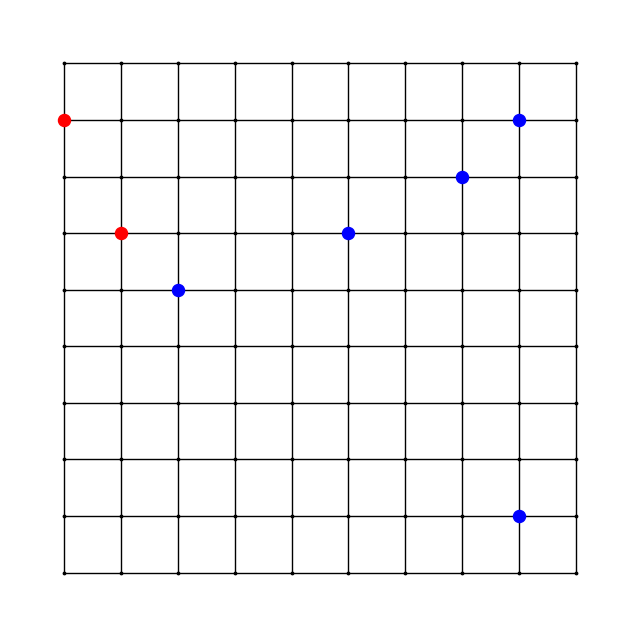

In [2]:
SHAPE = (30,30)
POI = 15
CHARGERS = 4
NEW_CHARGERS = 6

SHAPE = (10,10)
POI = 5
CHARGERS = 2
NEW_CHARGERS = 4

SEED = 42

qa = QuantumAnnealing(SHAPE, POI, CHARGERS, NEW_CHARGERS, hyperparams=np.array([2, 7, 7, 2]))
qa.draw_grid()

In [3]:
#hyper = qa.search_hyperparams([4, 3, 3, 3], num_reads=1)

Score:  74.77481569142547


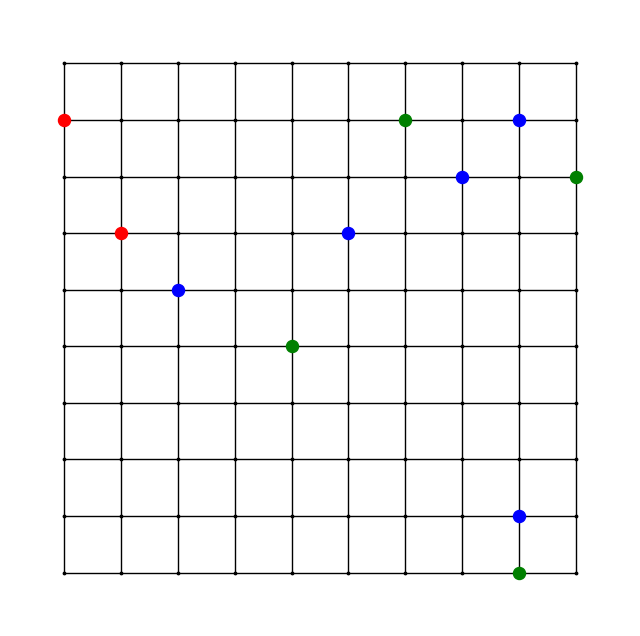

In [8]:
#
bqm = qa.build_bqm_numpy()

# Calculate score
sampleset = qa.run_bqm(bqm)
score = qa.score_sampleset(sampleset)

# Create scenario output image
print("Score: ", score)
qa.draw_grid()